In [1]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for machine learning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump,load
import shap

# Display setting for exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Check out if the environment is the correct Anaconda one
import sys
print('environment: ',sys.executable)

# Set up directory to be the github repository
# requires git
import os
import subprocess
os.getcwd()
output = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
path = output.decode('utf-8').strip()
print('working directory: ',path)
os.chdir(path)


environment:  c:\Users\ricca\anaconda3\envs\Thesis\python.exe
working directory:  C:/Users/ricca/Documents/GitHub/Thesis-SEM-ML


In [3]:
from Source.DataPreparation.DataProcessor import DataProcessor
from Source.Regression.latent_variable_regressors import GBoostRegression, RFRegression, LinearRegressionModel

In [4]:
# Assuming you have data in X and y variables
Results_RF = []
Results_XGB = []
Results_LM=[]
shap_values_list_RF = None
shap_values_list_xgb = None
shap_values_list_LM = None

montecarloiter=10

for i in range(montecarloiter):
    print(f"Starting the iteration n.{i+1}")

    processorclass=DataProcessor()
    processorclass.read_df()
    processorclass.split_data(test_size=0.3)
    processorclass.save_data()
    try:
        processorclass.process_CFA()
    except Exception as e:
        print(f"Error during process_CFA for iteration n.{i+1}: {e}")
        continue    

    X_train,y_train,X_test,y_test = processorclass.train_test_data_for_WEtarget(target_variable='WorkEngagement')

    # XGBRegressor
    Xgboost=GBoostRegression(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    Xgboost.train(verbosity=0,n_iter=90,cv=5)
    mxgbresults = Xgboost.get_results()
    mse_xgb, r2_xgb, mae_xgb, train_mse_xgb, train_r2_xgb = (mxgbresults['mse'],mxgbresults['r2'],mxgbresults['mae'],mxgbresults['train_mse'],mxgbresults['train_r2'])
    Results_XGB.append((mse_xgb, r2_xgb, mae_xgb,train_mse_xgb, train_r2_xgb))

    if shap_values_list_xgb is None:
        shap_values_list_xgb = Xgboost.get_shap_values()
    else:
        shap_values_list_xgb += Xgboost.get_shap_values()
    print(f"Iteration {i+1} XGBoost: MSE: {mse_xgb}, R^2: {r2_xgb}, MAE: {mae_xgb}, TRAIN_MSE:{train_mse_xgb}, TRAIN_R^2:{train_r2_xgb}" )


    # RandomForest
    RFRegre=RFRegression(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    RFRegre.median_imputation()
    RFRegre.train(verbosity=0,n_iter=30,computeshap=False)

    mRFresults = RFRegre.get_results()
    mse_RF, r2_RF, mae_RF, train_mse_RF, train_r2_RF  = (mRFresults['mse'],mRFresults['r2'],mRFresults['mae'],mRFresults['train_mse'],mRFresults['train_r2'])
    Results_RF.append((mse_RF, r2_RF, mae_RF, train_mse_RF, train_r2_RF))


    #if shap_values_list_RF is None:
    #    shap_values_list_RF = RFRegre.get_shap_values()
    #else:
    #    shap_values_list_RF += RFRegre.get_shap_values()
    print(f"Iteration {i+1} RandomForest: MSE: {mse_RF}, R^2: {r2_RF}, MAE: {mae_RF}, TRAIN_MSE:{train_mse_RF}, TRAIN_R^2:{train_r2_RF}" )


    # Linear Regression
    LMreg= LinearRegressionModel(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    LMreg.median_imputation()
    LMreg.train(computeshap=True)
    LMresults = LMreg.get_results()
    mse_LM, r2_LM, mae_LM, train_mse_LM, train_r2_LM  = (LMresults['mse'],LMresults['r2'],LMresults['mae'],LMresults['train_mse'],LMresults['train_r2'])
    Results_LM.append((mse_LM, r2_LM, mae_LM,train_mse_LM, train_r2_LM))

    if shap_values_list_LM is None:
        shap_values_list_LM = LMreg.get_shap_values()
    else:
        shap_values_list_LM += LMreg.get_shap_values()
    print(f"Iteration {i+1} Linear Regression: MSE: {mse_LM}, R^2: {r2_LM}, MAE: {mae_LM}, TRAIN_MSE:{train_mse_LM}, TRAIN_R^2:{train_r2_LM}")

    print(("-------------------------------------------------"))



#shap_values_list_RF /= montecarloiter
shap_values_list_xgb /= montecarloiter
shap_values_list_LM /= montecarloiter

Starting the iteration n.1
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 1 XGBoost: MSE: 0.0976236831949447, R^2: 0.773019828513841, MAE: 0.2419420294887226, TRAIN_MSE:0.052409483377319814, TRAIN_R^2:0.8826202781577768
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.


Iteration 1 RandomForest: MSE: 0.10304457211825116, R^2: 0.7604159781247661, MAE: 0.24536702274763708, TRAIN_MSE:0.01872338633864603, TRAIN_R^2:0.9580658739840617
Starting the Linear Regression training
Iteration 1 Linear Regression: MSE: 0.10175667521301024, R^2: 0.7634104058173203, MAE: 0.24865488438466277, TRAIN_MSE:0.07629821945007198, TRAIN_R^2:0.8291174955565007
-------------------------------------------------
Starting the iteration n.2
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 2 XGBoost: MSE: 0.09314718732387364, R^2: 0.8103905280807496, MAE: 0.24019376227521821, TRAIN_MSE:0.025719989304852947, TRAIN_R^2:0.9380260472363846
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Iteration 2 RandomForest: MSE: 0.09942585130052443, R^2: 0.7976097432264327, MAE: 0.24926469088669348, TRAIN_MSE:0.01812562400968352, TRAIN_R^2:0.9563251542264355
Starting the Linear Regression training
Iteration 2 Linear Regression: MSE: 0.08147064555273315, R^2: 0.8341591783500377, MAE: 0.22884771971087434, TRAIN_MSE:0.08055314501298305, TRAIN_R^2:0.8059020653226583
-------------------------------------------------
Starting the iteration n.3
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 3 XGBoost: MSE: 0.12061916675524087, R^2: 0.7331853949947813, MAE: 0.2741786976298887, TRAIN_MSE:0.03055192187399837, TRAIN_R^2:0.9300354819800061
Starting the Random Forest training with median imputation
Iteration 3 RandomForest: MSE: 0.13096880590792248, R^2: 0.7102915634690441, MAE: 0.2842512135009682, TRAIN_MSE:0.024260527375894785, TRAIN_R^2:0.9444429024214702
Starting the Linear

In [10]:
import numpy as np

def print_avg_metrics(Results, model_name):
    mse_avg = np.mean([res[0] for res in Results])
    r2_avg = np.mean([res[1] for res in Results])
    mae_avg = np.mean([res[2] for res in Results])
    train_mse_avg = np.mean([res[3] for res in Results])
    train_r2_avg = np.mean([res[4] for res in Results])
    
    print(f"Model: {model_name}")
    print(f"Average MSE over {montecarloiter} iterations: {mse_avg}")
    print(f"Average MAE over {montecarloiter} iterations: {mae_avg}")
    print(f"Average R^2 over {montecarloiter} iterations: {r2_avg}")
    print(f"Average Training  MSE over {montecarloiter} iterations: {train_mse_avg}")
    print(f"Average Training  R^2 over {montecarloiter} iterations: {train_r2_avg}")
    print("-------------------------------------------------")

# Print the metrics for each model
print_avg_metrics(Results_XGB, "XGBoost")
print_avg_metrics(Results_RF, "Random Forest")
print_avg_metrics(Results_LM, "Linear Model")

Model: XGBoost
Average MSE over 3 iterations: 0.10379667909135308
Average MAE over 3 iterations: 0.2521048297979432
Average R^2 over 3 iterations: 0.7721985838631239
Average Training  MSE over 3 iterations: 0.03622713151872371
Average Training  R^2 over 3 iterations: 0.9168939357913892
-------------------------------------------------
Model: Random Forest
Average MSE over 3 iterations: 0.11114640977556602
Average MAE over 3 iterations: 0.25962764237843294
Average R^2 over 3 iterations: 0.7561057616067477
Average Training  MSE over 3 iterations: 0.020369845908074776
Average Training  R^2 over 3 iterations: 0.9529446435439892
-------------------------------------------------
Model: Linear Model
Average MSE over 3 iterations: 0.10166849565764097
Average MAE over 3 iterations: 0.25086698991283457
Average R^2 over 3 iterations: 0.7760637414174864
Average Training  MSE over 3 iterations: 0.07423757802787694
Average Training  R^2 over 3 iterations: 0.8280652315077482
-------------------------

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


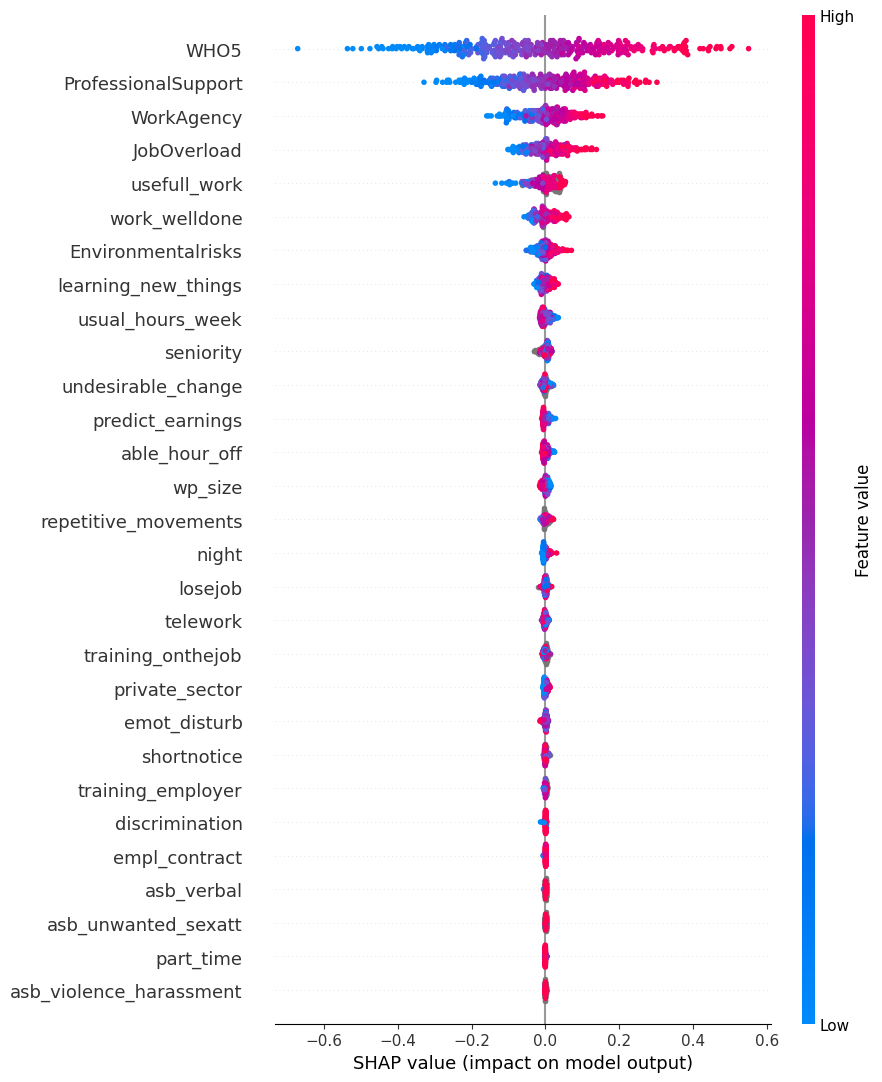

In [11]:
shap.plots.beeswarm(shap_values_list_xgb, max_display=30)

In [7]:
#shap.waterfall_plot(shap_values_list_xgb[2])


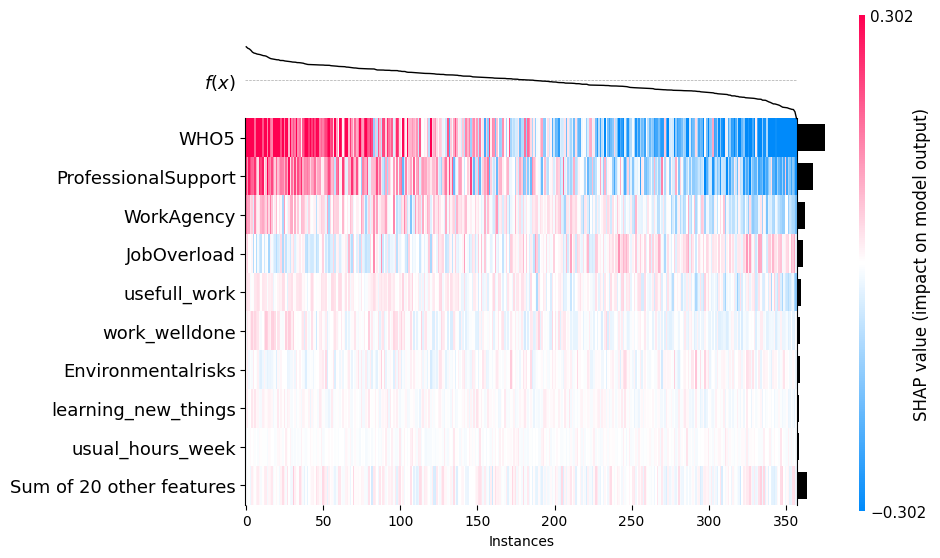

In [14]:
shap.plots.heatmap(shap_values_list_xgb, instance_order=shap_values_list_xgb.sum(1))

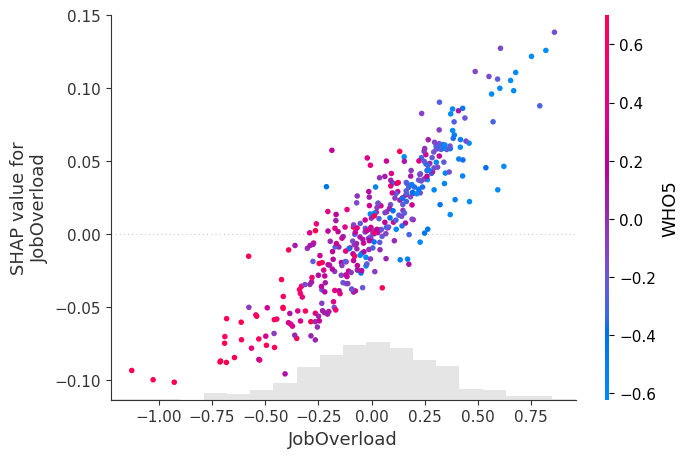

In [16]:
shap.plots.scatter(shap_values_list_xgb[:, "JobOverload"],color=shap_values_list_xgb[:, "WHO5"])
#color=plt.get_cmap("cool")
#color=shap_values[:,"Workclass"])
